# State space analysis on RNNs without drift

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Wedge, FancyArrowPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from dynamic_bias import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/rnn")

ra = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/demo_rnn_activity.pickle')
ss = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_state_space.pickle')
params = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/params_connectivity.pickle')

downloading data/outputs/rnn...
data/outputs/rnn already exists. Skipping download...


---
## State dynamics without drift

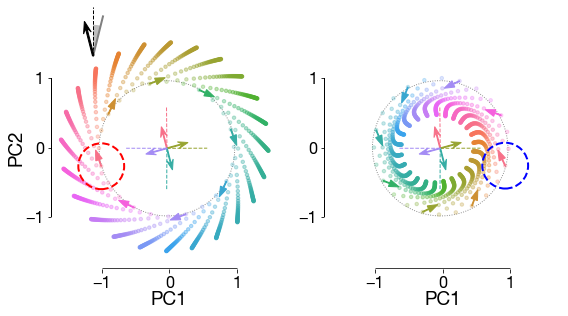

In [3]:
# visualization params
strt         = 39   # starting time step 
dura         = 29   # duration time steps
scale_center = 1.0
scale_length = 0.1
scale_ref    = 0.6
scale_stm    = 0.3

# make ellipse
rrr = np.stack([ss['hom_r1_cw'][(strt-2):(strt+1),s,1].mean(axis=0) for s in range(24)])
center = np.mean(rrr, axis=0)
eparams = utils.fit_centered_ellipse( *(rrr-center).T )
rrr = utils.rotate(utils.harmonics(num=250).T, phi=eparams['phi'], w=eparams['w']).T + center[:,None]

# align state space
stim_list  = np.linspace(0,np.pi*2,num=24,endpoint=False)
ref_inputs = np.roll(ss['ref_input'], 1, axis=0)
ref_inputs = (ref_inputs - np.roll(ref_inputs, 12, axis=0))/2.

# plot
fig, ax = plt.subplots(1,2)
utils.set_size([6,3])

## [1] draw ellipse
for i in range(2): 
    ax[i].plot(rrr[1], rrr[0], color='gray', linestyle='dotted', linewidth=0.9, zorder=-3)

## [2] draw reference directions 
for s in np.arange(24,step=6):      
    vec = ss['hom_r2'][strt,s,0,:]

    for i in range(2):
        ax[i].arrow(*center[::-1], *(ref_inputs[s][::-1]*scale_ref), color=utils.HUSL.colors[s], 
                    width=0.012, head_width=0.1, zorder=3, overhang=0.4)
        ax[i].plot([center[1], vec[1]*scale_stm + center[1]], [center[0], vec[0]*scale_stm + center[0]], 
                   color=utils.HUSL.colors[s], linewidth=1, linestyle='dashed' )

## [3] draw population representations
for s in np.arange(24): 
    transw = ss['hom_r1_cw'] [strt:(strt+dura),s,0,:]
    transl = ss['hom_r1_ccw'][strt:(strt+dura),s,0,:]
    ax[0].scatter(transw[:,1], transw[:,0], alpha=np.linspace(0,1,40)[10:],
                  color=utils.HUSL.colors[s], s=12)
    ax[1].scatter(transl[:,1], transl[:,0], alpha=np.linspace(0,1,40)[10:],
                  color=utils.HUSL.colors[s], s=12)

    if s == 0:
        ax[0].scatter(*(transw[0,1], transw[0,0]), s=2100, facecolors='none', 
                      edgecolors='r', linestyle='dashed', lw=2, zorder=4)
        ax[1].scatter(*(transl[0,1], transl[0,0]), s=2100, facecolors='none', 
                      edgecolors='b', linestyle='dashed', lw=2, zorder=4)

    if s % 3 == 0:
        p, dp = utils.arrow(transw[0,::-1], transw[4,::-1], project=False)
        ax[0].arrow(*(p*scale_center), *(dp*scale_length), 
                    width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])
        p, dp = utils.arrow(transl[0,::-1], transl[4,::-1], project=False)
        ax[1].arrow(*(p*scale_center), *(dp*scale_length), 
                    width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])


for i in range(2): 
    ax[i].set_xlim([-1.75,1.75])
    ax[i].set_ylim([-1.75,1.75])
    utils.draw_publish_axis(ax[i], xrange=(-1,1), yrange=(-1,1), xticks=[-1,0,1], yticks=[-1,0,1])

if utils.LABEL:
    ax[0].set_ylabel("PC2", labelpad=0)
    ax[0].set_xlabel("PC1", labelpad=0)
    ax[1].set_xlabel("PC1", labelpad=0)

# inset
bbox = (-0.6, 0.1, 1,1)
inset_ax = inset_axes(ax[0], width="40%", height="40%", bbox_to_anchor=bbox, bbox_transform=ax[0].transAxes)

ang1 = np.pi / 2
ang2 = np.pi / 2 - 0.25
inset_ax.arrow(*[0, 0], *(ref_inputs[0][::-1] * 0.5), color='k', 
               width=0.01, head_width=0.05, zorder=3, overhang=0.4)
inset_ax.plot([0, 0], [0, 0.3], color='k', linewidth=1, linestyle='dashed')

inset_ax.plot([0, np.cos(ang2) * 0.25], [0, np.sin(ang2) * 0.25], color='gray', linewidth=2)
wedge = Wedge(center=(0, 0), r=0.01, alpha=0.5,
              theta1=np.rad2deg(utils.wrap(ang2 - np.pi)), 
              theta2=np.rad2deg(utils.wrap(ang1 - np.pi)), 
              width=0.2, lw=0, color='gray', transform=inset_ax.transData)
inset_ax.add_patch(wedge)
inset_ax.set_xlim([-0.3, 0.3])
inset_ax.set_ylim([-0.3, 0.3])
inset_ax.axis('off')  # Hide the inset axes frame

plt.savefig(f'{utils.DIR_FIGURE}/fig7bc.pdf',bbox_inches='tight',transparent=True)
plt.show()

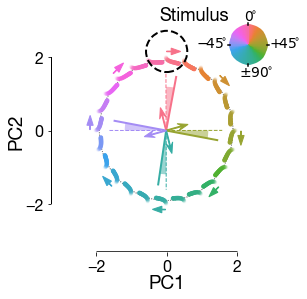

In [4]:
# visualization params
strt         = 39   # starting time step 
dura         = 29   # duration time steps
scale_center = 1.1
scale_length = 0.5
scale_ref    = 1.2
scale_stm    = 0.8

# make ellipse
rrr = np.stack([ss['hom_r2'][strt:(strt+dura),s,1].mean(axis=0) for s in range(24)])
center = np.mean(rrr, axis=0)
eparams = utils.fit_centered_ellipse( *(rrr-center).T )
rrr = utils.rotate(utils.harmonics(num=250).T, phi=eparams['phi'], w=eparams['w']).T + center[:,None]

# plot
f = plt.figure()
ax = plt.gca()
utils.set_size([3,3])

## [1] draw ellipse
for i in range(2): 
    ax.plot(rrr[1], rrr[0], color='gray', linestyle='dotted', linewidth=0.9, zorder=-3)

## [2] draw reference directions 
for s in np.arange(24,step=6): 
    ax.arrow(*center[::-1], *(ref_inputs[s][::-1]*scale_ref), color=utils.HUSL.colors[s], 
             width=0.024, head_width=0.2, zorder=3, overhang=0.4)

## [3] draw population representations
for s in np.arange(24): 
    vec = ss['hom_r2'][strt:(strt+dura),s,0]
    ax.scatter(vec[:,1], vec[:,0], alpha=np.linspace(0,1,30), color=utils.HUSL.colors[s], s=12)

    if s in [0,6,12,18]:
        ## draw first & last lines
        ax.plot( [center[1], vec[ 0,1]*scale_stm], [center[0], vec[ 0,0]*scale_stm], 
                 color=utils.HUSL.colors[s], linewidth=1, linestyle='dashed' )
        ax.plot( [center[1], vec[-1,1]*scale_stm], [center[0], vec[-1,0]*scale_stm], 
                 color=utils.HUSL.colors[s], linewidth=2 )

        ## draw bias angle
        ang1 = np.arctan2(vec[ 0,0], vec[ 0,1])
        ang2 = np.arctan2(vec[-1,0], vec[-1,1])
        wedge = Wedge(center=[0,0], r=0.01, alpha=0.5,
                      theta1=np.rad2deg(utils.wrap(ang2-np.pi)), 
                      theta2=np.rad2deg(utils.wrap(ang1-np.pi)), 
                      width=1.2, lw=0, color=utils.HUSL.colors[s], transform=ax.transData)
        ax.add_patch(wedge)
    
    if s % 3 == 0:
        p, dp = utils.arrow(np.mean(vec[:10,::-1],axis=0), np.mean(vec[-10:,::-1],axis=0))
        ax.arrow(*(p*scale_center), *(dp*scale_length), 
                  width=0.018, head_width=0.18, zorder=3, color=utils.HUSL.colors[s])

    if s == 0:
        ax.scatter(*(p*scale_center), s=1700, facecolors='none', 
                   edgecolors='k', linestyle='dashed', lw=2, zorder=4)

ax.set_xlim([-3.3,3.3])
ax.set_ylim([-3.3,3.3])
utils.draw_publish_axis(ax, xrange=(-2,2), yrange=(-2,2), xticks=[-2,0,2], yticks=[-2,0,2])

if utils.LABEL:
    ax.set_ylabel("PC2", labelpad=0)
    ax.set_xlabel("PC1", labelpad=0)

# Create inset
inset_ax = inset_axes(ax, width="25%", height="25%", loc='upper right')

x, y, r = 0, 0, 1
re, im  = np.mgrid[-1:2:100j, -1:2:100j]
angle   = np.angle(re + 1j*im)
angle   = (angle - np.pi/2.) % (2*np.pi)
cmap    = LinearSegmentedColormap.from_list('', utils.HUSL.colors)
img     = inset_ax.pcolormesh(re, im, -angle, shading='auto', cmap=cmap)

# Change the wedge to cover the full circle
wedge = Wedge(center=(x, y), r=r, theta1=0, theta2=360, width=1., clip_on=False, transform=inset_ax.transData)
img.set_clip_path(wedge)
inset_ax.use_sticky_edges = False
inset_ax.margins(x=0.05, y=0.05)
inset_ax.set_xlim([-1.5, 1.5])
inset_ax.set_ylim([-1.5, 1.5])

dd = 0.05
for ang in [np.pi/2., -np.pi/2., np.pi, 0]:
    inset_ax.plot([np.cos(ang)*(1.-dd), np.cos(ang)*(1.+dd)], 
                  [np.sin(ang)*(1.-dd), np.sin(ang)*(1.+dd)], color='k', zorder=3)

ax.text(-0.2,3.0, 'Stimulus', size=18)
inset_ax.text(np.cos(np.pi/2.)-0.20,  np.sin(np.pi/2.)+0.15, r'$0\!\!^\circ$', size=14)
inset_ax.text(np.cos(0)+0.08, np.sin(0)-0.15, r'$+\!45\!\!^\circ$', size=14)
inset_ax.text(np.cos(np.pi)-1.7, np.sin(np.pi)-0.15, r'$-\!45\!\!^\circ$', size=14)
inset_ax.text(np.cos(-np.pi/2.)-0.50, np.sin(-np.pi/2.)-0.6, r'$\pm90\!\!^\circ$', size=14)
inset_ax.axis('off')

plt.savefig(f'{utils.DIR_FIGURE}/fig7d.pdf', bbox_inches='tight', transparent=True)
plt.show()

---
## Population activity profile

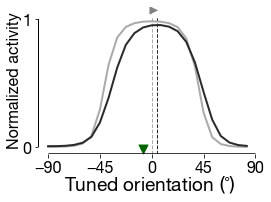

In [5]:
def min_normalize(vec):
    return vec - np.min(vec)

strt  = 39  # starting time step 
dura  = 29  # duration time steps

f,ax = plt.subplots(1,1)
utils.set_size([3,2])

# 
amp = 1./( np.max(ra['hom_r1_proj_cw'][strt+dura][0]) - np.min(ra['hom_r1_proj_cw'][strt+dura][0]) )
avg01 = utils.pop_vector_decoder(ra['hom_r1_proj_cw'][strt][0],  labels=np.arange(-90,90,step=7.5))
avg02 = utils.pop_vector_decoder(ra['hom_r1_proj_ccw'][strt][0], labels=np.arange(-90,90,step=7.5))
avg1 = utils.pop_vector_decoder(ra['hom_r1_proj_cw'][strt+dura][0],  labels=np.arange(-90,90,step=7.5))
avg2 = utils.pop_vector_decoder(ra['hom_r1_proj_ccw'][strt+dura][0], labels=np.arange(-90,90,step=7.5))

# 
ax.plot( np.arange(-90,90,step=7.5), ra['hom_r2'][strt]     [0], lw=2, color=utils.GRAYS.colors[1] )
ax.plot( np.arange(-90,90,step=7.5), ra['hom_r2'][strt+dura][0], lw=2, color=utils.GRAYS.colors[-1] )

avg = utils.pop_vector_decoder(ra['hom_r2'][strt+dura][0], labels=np.arange(-90,90,step=7.5))
ax.set_ylim([-0.05,1.1])
ax.scatter(-7.5, -0.01, marker="v", color='darkgreen', s=80)
ax.vlines(x=0.0, ymin=-0.05, ymax=1.02, color=utils.GRAYS.colors[1], linestyle='dashed', lw=1, zorder=1)
ax.vlines(x=avg, ymin=-0.05, ymax=1.02, color=utils.GRAYS.colors[-1], linestyle='dashed', lw=1, zorder=1)

# draw arrows
dd   = 1.2
dd   = 2.8
arr  = FancyArrowPatch((0,1.07), (avg+dd,1.07), arrowstyle='-|>',
                       mutation_scale=18, lw=0.8, color='gray', zorder=3)
ax.add_patch(arr)

if utils.LABEL:
    ax.set_ylabel("Normalized activity", labelpad=0, fontsize=16)
    f.text(0.55,-0.02, r"Tuned orientation $(\!\!^\circ\!\!)$", ha='center', size=19)

utils.draw_publish_axis(ax, xrange=(-90,90), yrange=(0,1), xticks=[-90,-45,0,45,90], yticks=[0,1])
plt.savefig(f'{utils.DIR_FIGURE}/fig7e.pdf',bbox_inches='tight', transparent=True)
plt.show()

---
## Linear choice-induced bias

In [6]:
# visualization params
strt   = 39    # starting time step 
gamr   = 0.54  # strength of reference
s      = 0     # stimulus index (in this case 0°)
rvec   = -np.pi/12.      # absolute reference orientation (in direction space)
origin = np.array([0,0]) 

#
stim_list  = np.linspace(0,np.pi*2,num=24,endpoint=False)
_r1cw  = ss['hom_r1_cw'][strt,:,0]
_r1ccw = ss['hom_r1_ccw'][strt,:,0]
w_phi  = np.arctan2(_r1cw[s,0],  _r1cw[s,1] )
l_phi  = np.arctan2(_r1ccw[s,0], _r1ccw[s,1])

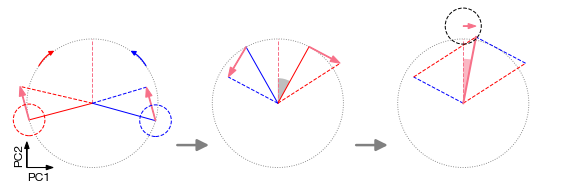

In [7]:
f,ax = plt.subplots(1,3, gridspec_kw={'wspace': 0.01})
utils.set_size([7.7,2.5])

# [0] relevant quantities
rvec0 = np.array( [np.sin(rvec),  np.cos(rvec)] )
w_p0  = np.array( [np.cos(w_phi), np.sin(w_phi)] )
l_p0  = np.array( [np.cos(l_phi), np.sin(l_phi)] )

## rotations 
### phi0 contribution + 90°
w_p1  = utils.rotate(w_p0,  -(params['J_param_hom']['J20'][0]-np.pi/2.))
l_p1  = utils.rotate(l_p0,  -(params['J_param_hom']['J21'][0]+np.pi/2.))
rvec1 = utils.rotate(rvec0, -(params['J_param_hom']['J20'][0]-np.pi/2.))
rvec2 = utils.rotate(rvec0, -(params['J_param_hom']['J21'][0]+np.pi/2.))

### phi1 contribution
w_p1  = utils.rotate(w_p1,  params['J_param_hom']['J02'][0])
l_p1  = utils.rotate(l_p1,  params['J_param_hom']['J12'][0])
rvec1 = utils.rotate(rvec1, params['J_param_hom']['J02'][0])
rvec2 = utils.rotate(rvec2, params['J_param_hom']['J12'][0])


# [1] draw the circle
lll = np.linspace(0,np.pi*2,250)
ccc = np.array([np.cos(lll), np.sin(lll)])
for i in range(3):
    ax[i].plot(ccc[0], ccc[1], color='gray', linestyle='dotted', linewidth=0.9)

# [2] upright stimulus vector
for i in range(3):
    ax[i].plot([0,0], [0,1], color=utils.HUSL.colors[s], linewidth=1, linestyle='dashed')


# [3] initial state [red, blue]
for i in range(2):
    ax[i].plot(*zip(origin, [w_p0,w_p1][i]), color='red', linewidth=1)
    ax[i].plot(*zip(origin, [l_p0,l_p1][i]), color='blue', linewidth=1)

# [3-1] circles
ax[0].scatter(*(w_p0), s=1000, facecolors='none', 
              edgecolors='r', linestyle='dashed', lw=1, zorder=4)
ax[0].scatter(*(l_p0), s=1000, facecolors='none', 
              edgecolors='b', linestyle='dashed', lw=1, zorder=4)


# [4] reference inputs
for i in range(2):
    ax[i].arrow(*([w_p0,w_p1][i]), *(gamr*[rvec0,rvec1][i]), 
             length_includes_head=True, width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])
    ax[i].arrow(*([l_p0,l_p1][i]), *(gamr*[rvec0,rvec2][i]), 
             length_includes_head=True, width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])

# [5] r(CW), r(CCW)
for i in range(3):
    p_cw  = [w_p0,w_p1,w_p1][i]+gamr*[rvec0,rvec1,rvec1][i]
    p_ccw = [l_p0,l_p1,l_p1][i]+gamr*[rvec0,rvec2,rvec2][i]
    ax[i].plot(*zip(origin, p_cw),  color='red',  linewidth=1, linestyle='dashed')
    ax[i].plot(*zip(origin, p_ccw), color='blue', linewidth=1, linestyle='dashed')

## add "phi1" wedge
phi_cw = np.arctan2( w_p1[1], w_p1[0] )
wedge = Wedge(center=(0,0), r=0.01, alpha=0.5,
              theta1=np.rad2deg(utils.wrap(phi_cw  - np.pi)), 
              theta2=np.rad2deg(utils.wrap(np.pi/2. - np.pi)), 
              width=.4, lw=0, color='gray', transform=ax[1].transData)
ax[1].add_patch(wedge)

## add "bias" wedge
p_sum = p_ccw+p_cw
p_phi = np.arctan2(p_sum[1], p_sum[0])
wedge = Wedge(center=(0,0), r=0.01, alpha=0.5,
              theta1=np.rad2deg(utils.wrap(p_phi    - np.pi)), 
              theta2=np.rad2deg(utils.wrap(np.pi/2. - np.pi)), 
              width=.7, lw=0, color=utils.HUSL.colors[s], transform=ax[2].transData)
ax[2].add_patch(wedge)

## add parallelogram
ax[2].plot(*zip(p_ccw, p_ccw+p_cw), color='red',  linewidth=1, linestyle='dashed')
ax[2].plot(*zip(p_cw,  p_cw+p_ccw), color='blue', linewidth=1, linestyle='dashed')
ax[2].plot(*zip(origin, p_sum),  linewidth=2, color=utils.HUSL.colors[s])

# [6] set lims
for i in range(3):
    ax[i].set_xlim([-1.3,1.5])
    ax[i].set_ylim([-1.3,1.5])
    ax[i].axis('off')

# [7] add moving arrows
for angs, ange, curv, col in zip(
    [np.pi*(2.5/8), -np.pi*(2.5/8)], [-np.pi/8, np.pi/8], [-0.16,0.16], ['red', 'blue']):
    a1  = np.pi/2 + angs
    a2  = a1 + ange
    c1  = np.array([np.cos(a1), np.sin(a1)])
    c2  = np.array([np.cos(a2), np.sin(a2)])
    arr = FancyArrowPatch(c1, c2, connectionstyle=f"arc3,rad={curv}", arrowstyle='-|>',
                          mutation_scale=10, lw=1.2, color=col, zorder=4)
    ax[0].add_patch(arr)
    
arrow = FancyArrowPatch((0.36, 0.3), (0.41, 0.3), mutation_scale=24, lw=2.5, color='gray', arrowstyle='-|>', transform=f.transFigure)
f.patches.append(arrow)
arrow = FancyArrowPatch((0.61, 0.3), (0.66, 0.3), mutation_scale=24, lw=2.5, color='gray', arrowstyle='-|>', transform=f.transFigure)
f.patches.append(arrow)

# [8] add bias arrow
chi = p_sum[0] # projection of the bias onto x axis
ax[2].arrow( 0,1.2, chi,0,
             width=0.01, head_width=0.08, zorder=3, 
             color=utils.HUSL.colors[s], length_includes_head=True)
ax[2].scatter( 0,1.2, s=1300, facecolors='none', 
               edgecolors='k', linestyle='dashed', lw=1, zorder=4)

# [*] add axis
ax[0].arrow(*[-1,-1], *[0.4,0], width=0.001, head_width=0.07, color='k', length_includes_head=True)
ax[0].arrow(*[-1,-1], *[0,0.4], width=0.001, head_width=0.07, color='k', length_includes_head=True)
ax[0].text(-1.00,-1.20, 'PC1', fontsize=12)
ax[0].text(-1.20,-0.95, 'PC2', fontsize=12, rotation='vertical')

plt.savefig(f'{utils.DIR_FIGURE}/fig7fgh.pdf', bbox_inches='tight', transparent=True)
plt.show()